In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import re

In [2]:
def create_dataset(fname):
    with open(fname, 'r',  encoding='utf-8') as f:
        nums = f.read().splitlines()
    data = pd.DataFrame(nums)
    data[0] = data[0].map(lambda s: re.sub('[^а-яА-Я,. ]','', s))
    data = data.replace('', np.NaN)
    data.dropna(inplace=True)
    s = data[0]
    s = s + '.'
    s = s.map(lambda s: s[0:-2] + '.' if s[-2:] in ['..', ' .'] else s)
    #s = s.map(lambda s: s[0:-1] + ' .' if s[-1:] in ['.'] else s)
    data[0] = s
    data = data.replace('', np.NaN)
    data.dropna(inplace=True)
    data.reset_index(drop = True, inplace=True)
    #data[0] = data[0].map(lambda s: np.array(s.split()))
    #print(data.to_numpy().shape)
    data = data.to_numpy()#.reshape(3138, -1)
    data = np.concatenate(data)
    return data
data = create_dataset('harry.txt')
data

array(['Джоанн Роулинг.', 'Гарри Поттер и Волшебный камень.', 'Глава.',
       ...,
       'Гарри задержался, чтобы попрощаться с Роном и Гермионой. Увидимся летом.',
       'Желаю тебе  эээ  хорошо провести каникулы, Гермиона неуверенно поглядела вслед дяде Вернону, шокированная его грубостью.',
       'Постараюсь, ответил Гарри, и его друзья удивились, увидев, как по лицу мальчика расползается торжествующая улыбка, Они ведь не знают, что нам не позволяется колдовать дома. Мы с Дудли славно позабавимся этим летом.'],
      dtype=object)

In [3]:
class Vocab:
    def __init__(self, data):
      self.alphabet = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
      symbols = ' ,.'+ self.alphabet+self.alphabet.upper()
      self.char2idx = {symbols[i]: i+10 for i in range(len(symbols))}
      self.idx2char = {i: symbols[i-10] for i in range(10, 77)}
      print(self.char2idx)
      print(self.idx2char)
    
    def tokenize(self, sequence):
        # выполните какой-то базовый препроцессинг
        # например, оставьте только алфавит и пунктуацию
        #print(sequence)
        return [self.char2idx[char] for char in sequence]
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    def __len__(self):
        return len(self.char2idx)

In [4]:
class TextDataset:
    def __init__(self, data_path):
        # загрузите данные
        data = create_dataset(data_path)

        # обучите вокаб
        self.vocab = Vocab(data)

        data_idx = []
        #for i in data:
          #data_idx.append(self.vocab.tokenize(i))
        #print(data_idx)
        # разделите данные на отдельные сэмплы для обучения
        # (просто список из сырых строк)
        self.data = data
        #return self.data
    
    def __len__(self):
        return len(self.data)  
    
    def __getitem__(self, idx):
        maxlen = 150
        sample = self.data[idx]
        #print(sample)
        sample = torch.LongTensor(self.vocab.tokenize(sample))
        
        if maxlen - len(sample) > 0:
          sample = torch.concat((sample, torch.zeros(maxlen - len(sample))))
        else:
          sample = sample[:150]
        #print(sample, sample.shape)
        sample = torch.LongTensor([*sample, 0])
        sample = sample.long()# сконвертируйте в LongTensor
        target = torch.LongTensor([0, *sample[:-1]])# нужно предсказать эту же последовательность со сдвигом 1
        #print(sample, sample.shape)
        return sample, target

In [5]:
text = TextDataset('harry.txt')
#torch.LongTensor([0, *[1,2,3,4,5]])

{' ': 10, ',': 11, '.': 12, 'а': 13, 'б': 14, 'в': 15, 'г': 16, 'д': 17, 'е': 18, 'ж': 19, 'з': 20, 'и': 21, 'й': 22, 'к': 23, 'л': 24, 'м': 25, 'н': 26, 'о': 27, 'п': 28, 'р': 29, 'с': 30, 'т': 31, 'у': 32, 'ф': 33, 'х': 34, 'ц': 35, 'ч': 36, 'ш': 37, 'щ': 38, 'ъ': 39, 'ы': 40, 'ь': 41, 'э': 42, 'ю': 43, 'я': 44, 'А': 45, 'Б': 46, 'В': 47, 'Г': 48, 'Д': 49, 'Е': 50, 'Ж': 51, 'З': 52, 'И': 53, 'Й': 54, 'К': 55, 'Л': 56, 'М': 57, 'Н': 58, 'О': 59, 'П': 60, 'Р': 61, 'С': 62, 'Т': 63, 'У': 64, 'Ф': 65, 'Х': 66, 'Ц': 67, 'Ч': 68, 'Ш': 69, 'Щ': 70, 'Ъ': 71, 'Ы': 72, 'Ь': 73, 'Э': 74, 'Ю': 75, 'Я': 76}
{10: ' ', 11: ',', 12: '.', 13: 'а', 14: 'б', 15: 'в', 16: 'г', 17: 'д', 18: 'е', 19: 'ж', 20: 'з', 21: 'и', 22: 'й', 23: 'к', 24: 'л', 25: 'м', 26: 'н', 27: 'о', 28: 'п', 29: 'р', 30: 'с', 31: 'т', 32: 'у', 33: 'ф', 34: 'х', 35: 'ц', 36: 'ч', 37: 'ш', 38: 'щ', 39: 'ъ', 40: 'ы', 41: 'ь', 42: 'э', 43: 'ю', 44: 'я', 45: 'А', 46: 'Б', 47: 'В', 48: 'Г', 49: 'Д', 50: 'Е', 51: 'Ж', 52: 'З', 53: 'И',

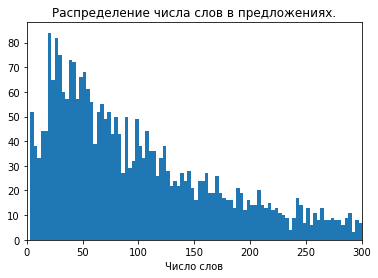

In [6]:
plt.hist([len(x) for x in text.data], bins=350)
plt.title('Распределение числа слов в предложениях.')
plt.xlabel('Число слов')
plt.xlim((0, 300))
plt.show()

In [7]:
min_len = 40  # предложения с меньшим количеством символов не будут рассматриваться
max_len = 150 # предложения с большим количеством символов будут обрезаться
#Разобьём на обучение и валидацию:

In [8]:
dataset = TextDataset('harry.txt')

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

{' ': 10, ',': 11, '.': 12, 'а': 13, 'б': 14, 'в': 15, 'г': 16, 'д': 17, 'е': 18, 'ж': 19, 'з': 20, 'и': 21, 'й': 22, 'к': 23, 'л': 24, 'м': 25, 'н': 26, 'о': 27, 'п': 28, 'р': 29, 'с': 30, 'т': 31, 'у': 32, 'ф': 33, 'х': 34, 'ц': 35, 'ч': 36, 'ш': 37, 'щ': 38, 'ъ': 39, 'ы': 40, 'ь': 41, 'э': 42, 'ю': 43, 'я': 44, 'А': 45, 'Б': 46, 'В': 47, 'Г': 48, 'Д': 49, 'Е': 50, 'Ж': 51, 'З': 52, 'И': 53, 'Й': 54, 'К': 55, 'Л': 56, 'М': 57, 'Н': 58, 'О': 59, 'П': 60, 'Р': 61, 'С': 62, 'Т': 63, 'У': 64, 'Ф': 65, 'Х': 66, 'Ц': 67, 'Ч': 68, 'Ш': 69, 'Щ': 70, 'Ъ': 71, 'Ы': 72, 'Ь': 73, 'Э': 74, 'Ю': 75, 'Я': 76}
{10: ' ', 11: ',', 12: '.', 13: 'а', 14: 'б', 15: 'в', 16: 'г', 17: 'д', 18: 'е', 19: 'ж', 20: 'з', 21: 'и', 22: 'й', 23: 'к', 24: 'л', 25: 'м', 26: 'н', 27: 'о', 28: 'п', 29: 'р', 30: 'с', 31: 'т', 32: 'у', 33: 'ф', 34: 'х', 35: 'ц', 36: 'ч', 37: 'ш', 38: 'щ', 39: 'ъ', 40: 'ы', 41: 'ь', 42: 'э', 43: 'ю', 44: 'я', 45: 'А', 46: 'Б', 47: 'В', 48: 'Г', 49: 'Д', 50: 'Е', 51: 'Ж', 52: 'З', 53: 'И',

In [16]:
class LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, tie_weights):
        super().__init__()
        
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.soft = nn.Softmax()
        
        if tie_weights:
            # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
            # https://arxiv.org/abs/1608.05859
            assert hidden_dim == embedding_dim
            self.decoder.weight = self.encoder.weight

        #self.rnn_type = rnn_type
        self.hidden_dim = hidden_dim
        self.nlayers = num_layers

    def forward(self, input, hidden):
        #print(input)
        #input = torch.tensor(input)
        emb = self.encoder(input)
        #print(emb.shape, hidden.shape)
        output, hidden = self.rnn(emb, hidden)
        decoded = self.decoder(output.view(output.size(0), output.size(1), output.size(2)))
        output = self.soft(decoded)
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, batch_size):
        # начальный хидден должен быть нулевой
        # (либо хоть какой-то константный для всего обучения)
        return torch.zeros(1, 151, self.hidden_dim)

In [17]:
epochs = 5
lr = 1e-3 
batch_size = 64

device = torch.device('cpu')

print(len(dataset.vocab))
model = LM(
    vocab_size = 151,
    embedding_dim = 128,
    hidden_dim = 128,
    num_layers = 1,
    dropout = 0.1,
    tie_weights= True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test = DataLoader(test_set, batch_size=batch_size)

67


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
for e in range(epochs):
    for x, y in train:
        model.train()    
        model.zero_grad()
        hidden = model.init_hidden(len(x))
        output, hidden = model(x, hidden)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
